In [456]:
import numpy as np
import random
from scipy.stats import bernoulli
from scipy import stats
import scipy
import scipy as sc
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from tqdm.notebook import tqdm

In [425]:
class Environment(object):
    '''General RL environment'''

    def __init__(self):
        pass

    def reset(self):
        pass

    def advance(self, action):
        '''
        Moves one step in the environment.
        Args:
            action
        Returns:
            reward - double - reward
            newState - int - new state
            pContinue - 0/1 - flag for end of the episode
        '''
        return 0, 0, 0

class Opt_Policy(object):
    '''
    For Computing Q*, the optimal q_values. This code was written with RiverSwim in mind.
    '''
    def __init__(self,env):
        self.env = env
        self.Q = np.zeros((self.env.epLen+1,self.env.nState,self.env.nAction))
        self.V = np.zeros((self.env.epLen+1,self.env.nState))
    
    def update(self):
        Q = np.zeros((self.env.epLen + 1,self.env.nState,self.env.nAction))
        V = np.zeros((self.env.epLen + 1,self.env.nState))
        for h in range(self.env.epLen-1,-1,-1):
            for s in range(self.env.nState):
                for a in range(self.env.nAction):
                    reward = env.R[s,a][0]
                    '''
                    for s_ in range(self.env.nState):
                        #print(s,a,s_)
                        reward += self.env.R[s,a,s_][0]*self.env.P[s,a][s_]
                    '''
                    p = env.P[s,a]
                    Q[h,s,a] = reward + np.inner(p,V[h+1,:])
                V[h,s] = max(Q[h,s,:])
        self.Q = Q.copy()
        self.V = V.copy()
    
    def act(self,s,h):
        return env.argmax(self.Q[h,s,:])
    

In [426]:
def make_riverSwim(epLen=20, nState=5):
    '''
    Makes the benchmark RiverSwim MDP.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment '''
    nAction = 2
    R_true = {}
    P_true = {}
    states = {}
    for s in range(nState):
        states[(s)] = 0.0
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    R_true[0, 0] = (5/1000, 0)
    R_true[nState - 1, 1] = (1, 0)

    # Transitions
    for s in range(nState):
        P_true[s, 0][max(0, s-1)] = 1.

    for s in range(1, nState - 1):
        P_true[s, 1][min(nState - 1, s + 1)] = 0.3
        P_true[s, 1][s] = 0.6
        P_true[s, 1][max(0, s-1)] = 0.1

    P_true[0, 1][0] = 0.3
    P_true[0, 1][1] = 0.7
    P_true[nState - 1, 1][nState - 1] = 0.9
    P_true[nState - 1, 1][nState - 2] = 0.1
    
    P_arr = np.zeros((nState,nAction,nState))
    for s in range(nState):
        for a in range(nAction):
            P_arr[s,a,:] = P_true[s,a]
            

    riverSwim = TabularMDP(nState, nAction, epLen)
    riverSwim.R = R_true
    riverSwim.P = P_true
    riverSwim.Parr = P_arr
    riverSwim.states = states
    riverSwim.reset()

    return riverSwim

def make_MDP(epLen=2,nBottom = 24):
    '''
    Makes the benchmark RiverSwim MDP.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment '''
    nState = nBottom + 3
    nAction = 2
    R_true = {}
    P_true = {}
    states = {}
    for s in range(nState):
        states[(s)] = 0.0
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    R_true[1,0] = (0, 0)
    R_true[1,1] = (0, 0)
    R_true[2,0] = (1, 0)
    R_true[2,1] = (1, 0)
    n = int(nBottom/4)
    #Transitions 
    P_true[0,0][1] = 1.0
    P_true[0,1][2] = 1.0
    P_true[1,0][3:3+n] = 1/n
    P_true[1,1][3+n:3+2*n] = 1/n
    P_true[2,0][3+2*n:3+3*n] = 1/n
    P_true[2,1][3+3*n:3+4*n] = 1/n
    

    MDP = TabularMDP(nState, nAction, epLen)
    MDP.R = R_true
    MDP.P = P_true
    MDP.states = states
    MDP.reset()

    return MDP

class TabularMDP(Environment):
    '''
    Tabular MDP
    R - dict by (s,a) - each R[s,a] = (meanReward, sdReward)
    P - dict by (s,a) - each P[s,a] = transition vector size S
    '''

    def __init__(self, nState, nAction, epLen):
        '''
        Initialize a tabular episodic MDP
        Args:
            nState  - int - number of states
            nAction - int - number of actions
            epLen   - int - episode length
        Returns:
            Environment object
        '''

        self.nState = nState
        self.nAction = nAction
        self.epLen = epLen

        self.timestep = 0
        self.state = 0

        # Now initialize R and P
        self.R = {}
        self.P = {}
        self.states = {}
        for state in range(nState):
            for action in range(nAction):
                self.R[state, action] = (1, 1)
                self.P[state, action] = np.ones(nState) / nState
                
    def reset(self):
        "Resets the Environment"
        self.timestep = 0
        self.state = 0
        
    def advance(self,action):
        '''
        Move one step in the environment
        Args:
        action - int - chosen action
        Returns:
        reward - double - reward
        newState - int - new state
        episodeEnd - 0/1 - flag for end of the episode
        '''
        if self.R[self.state, action][1] < 1e-9:
            # Hack for no noise
            reward = self.R[self.state, action][0]
        else:
            reward = np.random.normal(loc=self.R[self.state, action][0],
                                      scale=self.R[self.state, action][1])
        #print(self.state, action, self.P[self.state, action])
        newState = np.random.choice(self.nState, p=self.P[self.state, action])
        
        # Update the environment
        self.state = newState
        self.timestep += 1

        episodeEnd = 0
        if self.timestep == self.epLen:
            episodeEnd = 1
            #newState = None
            self.reset()

        return reward, newState, episodeEnd
    
    def argmax(self,b):
        #print(b)
        return np.random.choice(np.where(b == b.max())[0])

In [435]:
class UCRL_VTR(object):
    '''
    Algorithm 1 as described in the paper Model-Based RL with
    Value-Target Regression
    The algorithm assumes that the rewards are in the [0,1] interval.
    '''
    def __init__(self,env,K,con,V,acting):
        self.env = env
        self.K = K
        self.con = con
        self.V_star = V
        self.acting = acting
        # A unit test that randomly explores for a period of time then learns from that experience
        # Here self.random_explore is a way to select a period of random exploration.
        # When the current episode k > total number of episodes K divided by self.random_explore
        # the algorithm switches to the greedy action with respect to its action value Q(s,a).
        # Here the dimension (self.d) for the Tabular setting is |S x A x S| as stated in Appendix B
        self.d = self.env.nState * self.env.nAction * self.env.nState
        # In the tabular setting the basis models is just the dxd identity matrix, see Appendix B
        self.P_basis = np.identity(self.d)
        #Our Q-values are initialized as a 2d numpy array, will eventually convert to a dictionary
        self.Q = {(h,s,a): 0.0 for h in range(self.env.epLen) for s in self.env.states.keys() \
                   for a in range(self.env.nAction)}
        self.Q_mean = np.zeros((self.env.epLen,self.env.nState,self.env.nAction))
        #Our State Value function is initialized as a 1d numpy error, will eventually convert to a dictionary
        self.V = {(h,s): 0.0 for s in self.env.states.keys() for h in range(env.epLen + 1)} # self.V[env.epLen] stays zero
        #self.create_value_functions()
        #The index of each (s,a,s') tuple, see Appendix B
        self.sigma = {}
        self.mu = np.zeros((self.env.epLen,self.env.nState,self.env.nAction))
        self.state_idx = {}
        self.createIdx()
        #See Step 2, of algorithm 1
#         self.M = env.epLen**2*self.d*np.identity(self.d)
        # For use in the confidence bound bonus term, see Beta function down below
        self.B = np.linalg.norm(self.env.Parr)
        self.theta_star = self.env.Parr.reshape(self.d)
        self.lam = 1/self.B**2
        #Self.L is no longer need, but will keep for now.
        self.L = 1.0
        self.M = np.identity(self.d)*self.lam
        self.M_tilde = np.identity(self.d)*self.lam
        self.Minv = np.linalg.inv(self.M)
        self.M_tilde_inv = np.linalg.inv(self.M_tilde)
        #See Step 2
        self.w = np.zeros(self.d)
        self.w_tilde = np.zeros(self.d)
        #See Step 2
        self.theta = np.dot(self.Minv,self.w)
        self.theta_tilde = np.zeros(self.d)
        #See Step 3
        self.delta = 1/self.K
        #m_2 >= the 2-norm of theta_star, see Bandit Algorithms Theorem 20.5
        #self.error()
        #self.m_2 = np.linalg.norm(self.true_p) + 0.1
        self.m_2 = np.sqrt(self.env.nState*self.env.nAction)
        self.H = self.env.epLen
        self.d1 = env.nState * env.nAction
        self.sigma_bar = np.zeros((self.H,self.env.nState,self.env.nAction))
        #self.sigma_bar = np.zeros(self.H)
        self.E = np.zeros((self.H,self.env.nState,self.env.nAction))
        self.Info = np.zeros((self.H,self.env.nState,self.env.nAction))
        self.instant_reg = np.zeros((self.H,self.env.nState,self.env.nAction))
        self.beta_hat = 8*np.sqrt(self.d) + 4*np.sqrt(self.d)
        self.beta1 = 8*self.d + 4*np.sqrt(self.d) + np.sqrt(self.lam)*self.B
        self.beta_tilde = (self.H**2)*(8*np.sqrt(self.d)) + np.sqrt(self.lam)*self.B




    def feature_vector(self,s,a,h):
        '''
        Returning sum_{s'} V[h+1][s'] P_dot(s'|s,a),
        with V stored in self.
        Inputs:
            s - the state
            a - the action
            h - the current timestep within the episode
        '''
        sums = np.zeros(self.d)
        for s_ in self.env.states.keys():
            #print(s,s_)
            sums += self.V[h+1,s_] * self.P_basis[self.sigma[(s,a,s_)]]
        return sums
    
    def feature_vector_star(self,s,a,h):
        '''
        Returning sum_{s'} V[h+1][s'] P_dot(s'|s,a),
        with V stored in self.
        Inputs:
            s - the state
            a - the action
            h - the current timestep within the episode
        '''
        sums = np.zeros(self.d)
        for s_ in self.env.states.keys():
            #print(s,s_)
            sums += self.V_star[h+1,s_] * self.P_basis[self.sigma[(s,a,s_)]]
        return sums
    
    
    def feature_vector_squared(self,s,a,h):
        '''
        Returning sum_{s'} V[h+1][s'] P_dot(s'|s,a),
        with V stored in self.
        Inputs:
            s - the state
            a - the action
            h - the current timestep within the episode
        '''
        sums = np.zeros(self.d)
        for s_ in self.env.states.keys():
            #print(s,s_)
            sums += pow(self.V[h+1,s_],2) * self.P_basis[self.sigma[(s,a,s_)]]
        return sums
    
    def feature_vector_squared_star(self,s,a,h):
        '''
        Returning sum_{s'} V[h+1][s'] P_dot(s'|s,a),
        with V stored in self.
        Inputs:
            s - the state
            a - the action
            h - the current timestep within the episode
        '''
        sums = np.zeros(self.d)
        for s_ in self.env.states.keys():
            #print(s,s_)
            sums += pow(self.V_star[h+1,s_],2) * self.P_basis[self.sigma[(s,a,s_)]]
        return sums
    

    def proj(self, x, lo, hi):
        '''Projects the value of x into the [lo,hi] interval'''
        return max(min(x,hi),lo)

    def update_Q(self,s,a,k,h):
        '''
        A function that updates both Q and V, Q is updated according to equation 4 and
        V is updated according to equation 2
        Inputs:
            s - the state
            a - the action
            k - the current episode
            h - the current timestep within the episode
        Currently, does not properly compute the Q-values but it does seem to learn theta_star
        '''
        #Here env.R[(s,a)][0] is the true reward from the environment
        # Alex's code: X = self.X[h,:]
        # Suggested code:
        X = self.feature_vector(s,a,h)
        #beta = self.Beta(h,self.M,1)
        beta = self.beta_hat
        width = np.sqrt(np.dot(np.dot(np.transpose(X),self.Minv),X))
        bonus = beta * width
        self.Q_mean[h,s,a] = self.env.R[(s,a)][0] + np.dot(X,self.theta)
        self.Q[h,s,a] = self.proj(self.Q_mean[h,s,a] + bonus,0,self.H)
        if self.acting == 'ids':
            self.V[h,s] = np.inner(self.mu[h,s,:],(np.array([self.Q[(h,s,a_)] for a_ in range(self.env.nAction)])))
            self.compute_info(s,a,h,width,k)
        elif self.acting == 'ucb':
            self.V[h,s] = max(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))
            
    def update_Qend(self,k):
        '''
        A function that updates both Q and V at the end of each episode, see step 16 of algorithm 1
        Inputs:
            k - the current episode
        '''
        #step 16
        for h in range(self.env.epLen-1,-1,-1):
            for s in self.env.states.keys():
                for a in range(self.env.nAction):
                    #Here env.R[(s,a)][0] is the true reward from the environment
                    # Alex's code: X = self.X[h,:]
                    # Suggested code:
                    self.update_Q(s,a,k,h)
                #self.V[h,s] = max(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))
    
    def compute_info(self,s,a,h,width,k):
        X = self.feature_vector(s,a,h)
        X_2 = self.feature_vector_squared(s,a,h)
        #sigma = np.inner(X_2,self.theta_star) - (np.inner(X,self.theta_star))**2
        self.sigma_bar[h,s,a] = np.sqrt(max((self.env.epLen)**2/self.d,np.inner(X_2,self.theta_star) - (np.inner(X,self.theta_star)**2)))
        sigma_bar = self.sigma_bar[h,s,a]
        self.Info[h,s,a] = np.log(1 + width**2 * (sigma_bar)**2)
    
    def compute_sigma(self,h):
        for s in range(self.env.nState):
            for a in range(self.env.nAction):
                '''
                      
                X = self.feature_vector(s,a,h)

                #Step 11 (Dongrou)
                X_2 = self.feature_vector_squared(s,a,h)

                Var_V = self.proj(np.inner(X_2,self.theta_tilde),0,(self.env.epLen-h)**2) \
                - (self.proj(np.inner(X,self.theta),0,self.env.epLen))**2

                #dot_hat = np.dot(np.linalg.inv(sc.linalg.sqrtm(self.M)),X)  
                dot_hat = np.sqrt(np.dot(np.dot(X,self.Minv),X))
                #dot_tilde = np.dot(np.linalg.inv(sc.linalg.sqrtm(self.M_tilde)),X_2)  
                dot_tilde = np.sqrt(np.dot(np.dot(X_2,self.M_tilde_inv),X_2))
                beta1 = self.Beta(h,self.M,1)
                beta2 = self.Beta(h,self.M_tilde,2)
                #beta1 = self.beta1
                #beta2 = self.beta_tilde
                self.E[h,s,a] = min((self.env.epLen)**2,2*(self.env.epLen-h)*beta1*np.linalg.norm(dot_hat)) + \
                            min((self.env.epLen)**2,beta2*np.linalg.norm(dot_tilde))


                #Step 12 (Dongrou)
                self.sigma_bar[h,s,a] = np.sqrt(max((self.env.epLen-h)**2/self.d,Var_V + self.E[h,s,a]))
                '''       
                X = self.feature_vector(s,a,h)
                X_2 = self.feature_vector_squared(s,a,h)
                self.sigma_bar[h,s,a] = np.sqrt(max((self.env.epLen**2)/self.d,np.inner(X_2,self.theta_star) - (np.inner(X,self.theta_star)**2)))

                    

    def update_stat(self,s,a,s_,h,k):
        '''
        A function that performs steps 9-13 of algorithm 1
        Inputs:
            s - the current state
            a - the action
            s_ - the next state
            k - the current episode
            h - the timestep within episode when s was visited (starting at zero)
        '''
        #Step 10
        #self.X[h,:] = self.feature_vector(s,a,h) # do not need to store this
        X = self.feature_vector(s,a,h)
        
        #Step 11 (Dongrou)
        X_2 = self.feature_vector_squared(s,a,h)
        '''
        Var_V = self.proj(np.inner(X_2,self.theta_tilde),0,(self.env.epLen-h)**2) \
        - (self.proj(np.inner(X,self.theta),0,self.env.epLen))**2
        
        
        #dot_hat = np.dot(np.linalg.inv(sc.linalg.sqrtm(self.M)),X)  
        dot_hat = np.sqrt(np.dot(np.dot(X,self.Minv),X))
        #dot_tilde = np.dot(np.linalg.inv(sc.linalg.sqrtm(self.M_tilde)),X_2)  
        dot_tilde = np.sqrt(np.dot(np.dot(X_2,self.M_tilde_inv),X_2))
        beta1 = self.Beta(h,self.M,1)
        beta2 = self.Beta(h,self.M_tilde,2)
        #beta1 = self.beta1
        #beta2 = self.beta_tilde
        self.E[h] = min((self.env.epLen)**2,2*(self.env.epLen-h)*beta1*np.linalg.norm(dot_hat)) + \
                    min((self.env.epLen)**2,beta2*np.linalg.norm(dot_tilde))
        
        
        #Step 12 (Dongrou)
        self.sigma_bar[h] = np.sqrt(max((self.env.epLen-h)**2/self.d,Var_V + self.E[h]))
        '''
        #self.sigma_bar[h] = np.inner(X_2,self.theta_star) - (np.inner(X,self.theta_star))**2 + self.con/np.sqrt(k*(h+1))
        #self.compute_sigma(h)
        self.sigma_bar[h,s,a] = np.sqrt(max((self.env.epLen**2)/self.d,np.inner(X_2,self.theta_star) - (np.inner(X,self.theta_star)**2)))
        #self.sigma_bar[h] = np.inner(X_2,self.theta_star) - (np.inner(X,self.theta_star))**2
        #Step 13 (Dongrou)
        self.M = self.M + 1/(self.sigma_bar[h,s,a]**2)*np.outer(X,X)
        self.Minv = np.linalg.inv(self.M)
        
        #Step 14(Dongrou)
        y = self.V[h+1,s_]
        self.w = self.w + 1/(self.sigma_bar[h,s,a]**2)*y*X
        
        #Step 15(Dongrou)
        self.M_tilde = self.M_tilde + np.outer(X_2,X_2)
        self.M_tilde_inv = np.linalg.inv(self.M_tilde)
        
        #Step 16 (Dongrou)
        y_2 = self.V[h+1,s_] ** 2
        self.w_tilde = self.w_tilde + y_2*X_2 
        
    def Beta(self,h,M,p):
        '''
        A function that return Beta_k according to Algorithm 1, step 3
        '''
        #Step 3
        #Confidence bound from Appendix F/Chapter 20 of Bandit Algorithms Chpt 20 (Lattimore/Szepesvari).
        first = np.sqrt(self.lam)*self.B
        (sign, logdet) = np.linalg.slogdet(M)
        det = sign * logdet
        second = ((self.env.epLen-h)**p)/2*np.sqrt(2*np.log(1/self.delta) + min(det,pow(10,10)) - np.log(pow(self.lam,self.d)))
        return first + second 
    
    def two_action_ratio(self, D1, D2, I1, I2):
        """
        computes optimal trade-off between two actions
        p_min = argmin_p ((1-p)*D1 + p*D2)**2/((1-p)*I1 + p*I2)
        returns p_min, Psi(p_min)
        """
        # if info gain is zero for both action, randomize uniformly
        if I1 == 0. and I2 == 0.:
            return 0.5, np.inf
        # make sure that D1 <= D2 by flipping the actions if necessary
        if D2 < D1:
            D1, D2 = D2, D1
            I1, I2 = I2, I1
            flip = True
        else:
            flip = False
        if I1 >= I2:
            p = 0.
            ratio = D1**2/I1
        elif D1 == D2: # I1 < I2
            p = 1.
            ratio = D2**2/I2
        elif D1 <= 1e-30:
            p = 0.
            ratio = 0.
        else:
            p = D1/(D2 - D1)
            p = p - 2*I1/(I2 - I1)
            p = max(0., min(1., p))  # clip to [0,1]
            ratio = ((1-p)*D1 + p*D2)**2/(((1-p)*I1 + p*I2) + 1e-20)
            # if ratio == np.inf:
            #     print(p, D1, D2, I1, I2)
        if flip:
            p = 1. - p
        #print(ratio)
        return p, ratio

    def update_param(self):
        '''
        Updates our approximation of theta_star at the end of each episode, see
        Step 15 of algorithm1
        '''
        #Step 17 (Dongrou)
        self.theta = np.matmul(self.Minv,self.w)
        self.theta_tilde = np.matmul(self.M_tilde_inv,self.w_tilde)

    def act(self,s,h,k):
        '''
        Returns the greedy action with respect to Q_{h,k}(s,a) for a \in A
        see step 8 of algorithm 1
        Inputs:
            s - the current state
            h - the current timestep within the episode
        '''
        if self.acting == "ids":
            qmax = max(self.Q[h,s,0],self.Q[h,s,1])
            gap_a0 = abs(qmax - self.Q_mean[h,s,0])
            gap_a1 = abs(qmax - self.Q_mean[h,s,1])
            p,ratio = self.two_action_ratio(gap_a0, gap_a1, self.Info[h,s,0], self.Info[h,s,1])
            self.mu[h,s,:] = np.array([1-p,p])
            return np.random.choice(2,p=self.mu[h,s,:])
        elif self.acting == 'ucb':
            return self.env.argmax(np.array([self.Q[(h,s,a)] for a in range(self.env.nAction)]))
        

    def createIdx(self):
        '''
        A simple function that creates sigma according to Appendix B.
        Here sigma is a dictionary who inputs is a tuple (s,a,s') and stores
        the interger index to be used in our basis model P.
        '''
        i = 0
        j = 0
        k = 0
        for s in self.env.states.keys():
            self.state_idx[s] = int(j)
            j += 1
            for a in range(self.env.nAction):
                for s_ in self.env.states.keys():
                    self.sigma[(s,a,s_)] = int(i)
                    i += 1


        
        
        #first = 8 * np.sqrt(self.d*np.log(1/self.delta)) + 4*np.sqrt(self.d)*np.log(1/self.delta) + np.sqrt(self.lam)*self.B
        #return first
    def getweightedL1(self):
        self.weights = self.count
        self.true_p = np.zeros((self.env.nState,self.env.nAction,self.env.nState))
        for s in range(self.env.nState):
            for a in range(self.env.nAction):
                for s_ in range(self.env.nState):
                    self.true_p[s,a,s_] = self.env.P[s,a][s_]
                    
                    #for numerical stability
                    if sum(self.count[s,a,:]) == 0:
                        self.weights[s,a,s_] = self.count[s,a,s_]/1.0
                        
                    else:
                        self.weights[s,a,s_] = self.count[s,a,s_]/sum(self.count[s,a,:])
                        
        self.weights = self.weights.reshape(env.nState*env.nAction*env.nState)
        self.true_p = self.true_p.reshape(env.nState*env.nAction*env.nState)
        temp = 0
        for i in range(env.nState*env.nAction*env.nState):
            temp += abs(self.theta[i]-self.true_p[i])*self.weights[i]
        return temp

    def run(self):
        '''
        Simulates the agent interacting with the environment over K episodes
        Input: Nothing
        Output: A Kx1 reward vector and a Kx1 model error vector
        '''
        R = []
        reward = 0.0
        #Stores counts for use in weighted L1 norm
        self.count = np.zeros((env.nState,env.nAction,env.nState))
        self.model_error = np.zeros(self.K)
        print(self.name())
        for k in tqdm(range(1,self.K+1)):
            self.env.reset()
            done = 0
            while done != 1:
                s = self.env.state
                h = self.env.timestep
                a = self.act(s,h,k)
                #print(a)
                r,s_,done = self.env.advance(a)
                self.count[s,a,s_] += 1
                reward += r
                self.update_stat(s,a,s_,h,k)
            self.update_param()
            self.update_Qend(k)
            R.append(reward)
            self.model_error[k-1] = self.getweightedL1()
            #print(self.sigma_bar)
        return R

    def name(self):
        if self.acting == 'ucb':
            return 'Running: UCRL_VTR'
        elif self.acting == 'ids':
            return 'Running: IDRL_VTR'


In [449]:
def save():
    '''
    A function that saves the data for the a given experiment after each run
    right now this saves the data under the DeepTree experimental data folder
    '''
    np.save("paper_vtr_data_deeptree/R_vtr",R_vtr)
    np.save("paper_vtr_data_deeptree/R_mat",R_mat)
    np.save("paper_vtr_data_deeptree/R_avg_eg_vtr",R_avg_vtr)
    np.save("paper_vtr_data_deeptree/R_avg_mat",R_avg_mat)
    np.save("paper_vtr_data_deeptree/R_eg_vtr",R_eg)
    np.save("paper_vtr_data_deeptree/R_mat_eg",R_mat_eg)

    np.save("paper_vtr_data_deeptree/model_vtr",model_vtr)
    np.save("paper_vtr_data_deeptree/model_mat",model_mat)
    np.save("paper_vtr_data_deeptree/model_eg_vtr",model_eg_vtr)
    np.save("paper_vtr_data_deeptree/model_eg_mat",model_eg_mat)
    
    np.save("paper_vtr_data_deeptree/sem_vtr",sem_vtr)
    np.save("paper_vtr_data_deeptree/sem_mat",sem_mat)


#Environment Episode
K = 50000
#Controls how many different states on would like to test on 
Trials = 5
#The number of Epsilon Greedy experiments to average over
Runs = 5
#The epsilon for the Eps Greedy methods
eps = 0.1



#Initialize Reward Vector for both UCRL-VTR and UC-MatrixRL
R_vtr_ucb = np.zeros((Trials,K))
R_vtr_ids = np.zeros((Trials,K))



#Initialize Reward Matrix for both EGRL-VTR and EG-Freq


#A Matrix that stores the AVERAGE reward for both EGRL-VTR and EG-Freq


#The SEM of the reward for the Epsilon Greedy Methods


#Stores the Weighted L1 Error for all algorithms
model_vtr_ucb = np.zeros((Trials,K))
model_vtr_ids = np.zeros((Trials,K))

num_state = 4

#Loops through multiple different states of a given environment
for i in tqdm(range(Trials)):
    
    #Initialize the environment for testing
    #env = make_MDP(epLen = 2,nBottom = (s+1)*4)
    env = make_riverSwim(epLen=4*(num_state),nState = num_state)
    optimal = Opt_Policy(env)
    optimal.update()
    #Runs UCRL-VTR and stores Reward/Model Error
    agent_vtr_ucb = UCRL_VTR(env,K,250,optimal.V,'ucb')
    R_vtr_ucb[i,:] = agent_vtr_ucb.run()
    model_vtr_ucb[i,:] = agent_vtr_ucb.model_error
    
    agent_vtr_ids = UCRL_VTR(env,K,250,optimal.V,'ids')
    R_vtr_ids[i,:] = agent_vtr_ids.run()
    model_vtr_ids[i,:] = agent_vtr_ids.model_error

    
    #Saves the data at the end of each "Trial"
    #save()



Running: UCRL_VTR



Running: IDRL_VTR



Running: UCRL_VTR



Running: IDRL_VTR



Running: UCRL_VTR



Running: IDRL_VTR



Running: UCRL_VTR



Running: IDRL_VTR



Running: UCRL_VTR



Running: IDRL_VTR


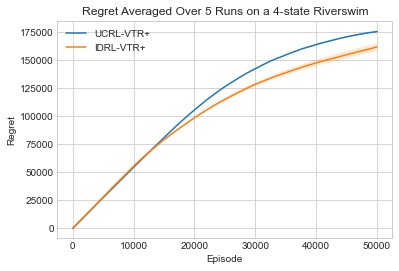

In [457]:
def regret(i,R):
    #[5.724564081209499,5.660391430300687,5.60134945831638]
    v = 5.660391430300687
    regret = np.zeros(len(R))
    for j in range(len(R)):
        regret[j] = abs((j+1)*v - R[j])
        
    return regret

plt.plot(regret(0,np.mean(R_vtr_ucb,axis=0)),label="UCRL-VTR+")
plt.fill_between(range(K),regret(0,np.mean(R_vtr_ucb,axis=0))-stats.sem(R_vtr_ucb,axis=0),regret(0,np.mean(R_vtr_ucb,axis=0))+stats.sem(R_vtr_ucb,axis=0),alpha=0.17)
plt.plot(regret(0,np.mean(R_vtr_ids,axis=0)),label="IDRL-VTR+")
plt.fill_between(range(K),regret(0,np.mean(R_vtr_ids,axis=0))-stats.sem(R_vtr_ids,axis=0),regret(0,np.mean(R_vtr_ids,axis=0))+stats.sem(R_vtr_ids,axis=0),alpha=0.17)

plt.legend()
plt.title("Regret Averaged Over 5 Runs on a 4-state Riverswim")
plt.ylabel("Regret")
plt.xlabel("Episode")
plt.savefig('idrl_regret.pdf')
plt.show()

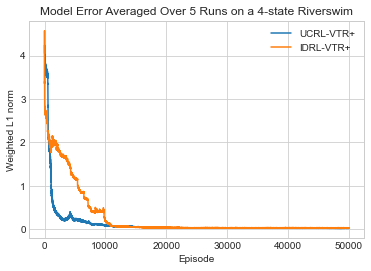

In [453]:
plt.plot(np.mean(model_vtr_ucb,axis=0),label='UCRL-VTR+')
plt.plot(np.mean(model_vtr_ids,axis=0),label='IDRL-VTR+')
plt.legend()
plt.title("Model Error Averaged Over 5 Runs on a 4-state Riverswim")
plt.xlabel("Episode")
plt.ylabel("Weighted L1 norm")
plt.savefig('idrl_error.pdf')
plt.show()

In [438]:
agent_vtr.sigma_bar

array([[[2.82842712, 2.82842712],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[2.82842712, 2.82842712],
        [2.82842712, 2.82842712],
        [0.        , 0.        ]],

       [[2.82842712, 2.82842712],
        [2.82842712, 2.82842712],
        [2.82842712, 2.82842712]],

       [[2.82842712, 2.82842712],
        [2.82842712, 2.82842712],
        [2.82842712, 2.82842712]],

       [[2.82842712, 2.82842712],
        [2.82842712, 2.82842712],
        [2.82842712, 2.82842712]],

       [[2.82842712, 2.82842712],
        [2.82842712, 2.82842712],
        [2.82842712, 2.82842712]],

       [[2.82842712, 2.82842712],
        [2.82842712, 2.82842712],
        [2.82842712, 2.82842712]],

       [[2.82842712, 2.82842712],
        [2.82842712, 2.82842712],
        [2.82842712, 2.82842712]],

       [[2.82842712, 2.82842712],
        [2.82842712, 2.82842712],
        [2.82842712, 2.82842712]],

       [[2.82842712, 2.82842712],
        [2.82842712, 2.8284271

In [420]:
agent_vtr.Q

{(0, 0, 0): 12,
 (0, 0, 1): 12,
 (0, 1, 0): 12,
 (0, 1, 1): 12,
 (0, 2, 0): 12,
 (0, 2, 1): 12,
 (1, 0, 0): 12,
 (1, 0, 1): 12,
 (1, 1, 0): 12,
 (1, 1, 1): 12,
 (1, 2, 0): 12,
 (1, 2, 1): 12,
 (2, 0, 0): 12,
 (2, 0, 1): 12,
 (2, 1, 0): 12,
 (2, 1, 1): 12,
 (2, 2, 0): 12,
 (2, 2, 1): 12,
 (3, 0, 0): 12,
 (3, 0, 1): 12,
 (3, 1, 0): 12,
 (3, 1, 1): 12,
 (3, 2, 0): 12,
 (3, 2, 1): 12,
 (4, 0, 0): 12,
 (4, 0, 1): 12,
 (4, 1, 0): 12,
 (4, 1, 1): 12,
 (4, 2, 0): 12,
 (4, 2, 1): 12,
 (5, 0, 0): 11.270086171598255,
 (5, 0, 1): 11.628794303800573,
 (5, 1, 0): 11.66296496506276,
 (5, 1, 1): 12,
 (5, 2, 0): 12,
 (5, 2, 1): 12,
 (6, 0, 0): 9.364837802751554,
 (6, 0, 1): 9.378215933932854,
 (6, 1, 0): 10.340282494670419,
 (6, 1, 1): 10.44671913317002,
 (6, 2, 0): 12,
 (6, 2, 1): 12,
 (7, 0, 0): 6.444069245399795,
 (7, 0, 1): 6.445897210195232,
 (7, 1, 0): 7.260572929015954,
 (7, 1, 1): 7.297875779328556,
 (7, 2, 0): 9.869399645680378,
 (7, 2, 1): 11.70506174152748,
 (8, 0, 0): 4.036019044092228,
 (8

In [421]:
agent_vtr.Q_mean

array([[[ 1.20049620e+01,  1.19994089e+01],
        [ 1.19999154e+01,  1.19993103e+01],
        [ 1.20003956e+01,  1.30001033e+01]],

       [[ 1.20049620e+01,  1.19994089e+01],
        [ 1.19999154e+01,  1.19993103e+01],
        [ 1.20003956e+01,  1.30001033e+01]],

       [[ 1.20049620e+01,  1.19994089e+01],
        [ 1.19999154e+01,  1.19993103e+01],
        [ 1.20003956e+01,  1.30001033e+01]],

       [[ 1.20049620e+01,  1.19994089e+01],
        [ 1.19999154e+01,  1.19993103e+01],
        [ 1.20003956e+01,  1.30001033e+01]],

       [[ 1.16338948e+01,  1.18934898e+01],
        [ 1.16289322e+01,  1.19608403e+01],
        [ 1.19993261e+01,  1.30055473e+01]],

       [[ 9.38346204e+00,  1.01368626e+01],
        [ 9.37855993e+00,  1.08104845e+01],
        [ 1.04453441e+01,  1.28617175e+01]],

       [[ 6.45085299e+00,  7.04176732e+00],
        [ 6.44572421e+00,  8.55718300e+00],
        [ 7.29951763e+00,  1.22805477e+01]],

       [[ 4.04096633e+00,  4.48731178e+00],
        [ 4.035853

In [422]:
agent_vtr.Info

array([[[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]]])

In [423]:
agent_vtr.mu

array([[[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.]]])